In [1]:
import os
import json
import logging
from typing import Tuple, Dict, Any, List

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

# Optuna and ARIMA are optional — gracefully handle if not installed
try:
    import optuna
except Exception:
    optuna = None

try:
    from statsmodels.tsa.arima.model import ARIMA
except Exception:
    ARIMA = None

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

# Helper: ensure directories
def ensure_dirs(paths: List[str]):
    for p in paths:
        os.makedirs(p, exist_ok=True)


In [2]:
# Cell 4: Data loader and synthetic generator

def load_air_quality(path: str) -> pd.DataFrame:
    """
    Attempt to load AirQualityUCI-like CSV. Handles common quirks:
    - semicolon separators with decimal commas
    - Date + Time combining
    - convert non-numeric to NaN and interpolate
    """
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    try:
        df = pd.read_csv(path, sep=';', decimal=',')
    except Exception:
        df = pd.read_csv(path)
    # Drop unnamed columns
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    # Combine Date & Time if present
    if {'Date', 'Time'}.issubset(df.columns):
        dt = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True, errors='coerce')
        df.index = dt
        df = df.drop(columns=['Date', 'Time'])
    # Convert to numeric
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    df = df.interpolate(limit_direction='both').fillna(method='ffill').fillna(method='bfill')
    return df

def generate_synthetic_series(n_samples: int = 15000, n_features: int = 4, noise: float = 0.12, random_state: int = 42) -> pd.DataFrame:
    """
    Create multi-feature correlated synthetic time series using a mix of sinusoids + AR-like smoothing.
    Returns DataFrame with hourly DatetimeIndex.
    """
    rng = np.random.RandomState(random_state)
    t = np.arange(n_samples)
    base1 = np.sin(2 * np.pi * t / 50.0)   # low freq
    base2 = np.sin(2 * np.pi * t / 7.0)    # mid freq
    base3 = np.cos(2 * np.pi * t / 3.0)    # higher freq
    data = []
    for i in range(n_features):
        w1, w2, w3 = rng.uniform(0.5, 1.5), rng.uniform(0.5, 1.5), rng.uniform(0.2, 1.0)
        series = w1*base1 + w2*base2 + w3*base3 + noise * rng.randn(n_samples)
        # small causal smoothing to introduce AR-like dependency
        for _ in range(2):
            series = 0.8 * np.roll(series, 1) + 0.2 * series
        data.append(series)
    df = pd.DataFrame(np.vstack(data).T, columns=[f'feat_{i}' for i in range(n_features)])
    df.index = pd.date_range(start='2000-01-01', periods=n_samples, freq='H')
    return df


In [3]:
# Cell 5: Load the dataset (prefers /mnt/data/AirQualityUCI.csv if present)
data_path = '/mnt/data/AirQualityUCI.csv'
if os.path.exists(data_path):
    logger.info(f"Found {data_path}, attempting to load.")
    try:
        df_raw = load_air_quality(data_path)
        logger.info("Loaded AirQuality dataset.")
    except Exception as e:
        logger.warning(f"Failed to load AirQuality file: {e}. Generating synthetic instead.")
        df_raw = generate_synthetic_series(n_samples=15000, n_features=4)
else:
    logger.info("No dataset file found, generating synthetic data.")
    df_raw = generate_synthetic_series(n_samples=15000, n_features=4)

# Quick look
print("Data shape:", df_raw.shape)
df_raw.head()


Data shape: (15000, 4)


/tmp/ipython-input-43084599.py:48: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.index = pd.date_range(start='2000-01-01', periods=n_samples, freq='H')


,feat_0,feat_1,feat_2,feat_3
2000-01-01 00:00:00,-1.460874,-1.016454,-1.084477,-1.505718
2000-01-01 01:00:00,-1.050545,-0.519723,-0.525948,-0.899975
2000-01-01 02:00:00,0.752863,0.841299,0.628309,0.738048
2000-01-01 03:00:00,1.050683,0.387996,0.352224,0.786249
2000-01-01 04:00:00,1.382223,0.844887,0.884986,1.264469


          count      mean       std       min       25%       50%       75%  \
feat_0  15000.0 -0.000850  1.132484 -2.653336 -0.827496 -0.008968  0.842947   
feat_1  15000.0 -0.000338  1.124151 -2.635995 -0.899606  0.000139  0.914442   
feat_2  15000.0  0.000375  0.964962 -2.276051 -0.745482  0.002804  0.757241   
feat_3  15000.0  0.000013  1.333567 -3.064172 -0.957625  0.004095  0.973539   

             max  
feat_0  2.589078  
feat_1  2.548577  
feat_2  2.229088  
feat_3  3.052862  


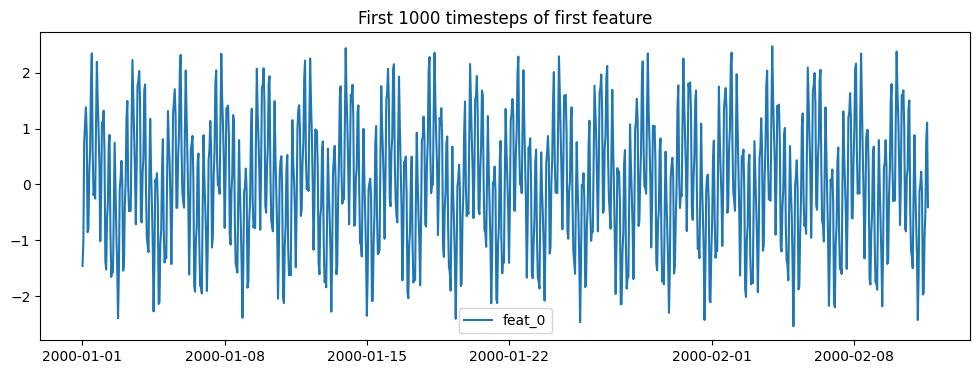

In [4]:
# Cell 6: EDA (basic)
print(df_raw.describe().T)

# Quick plot (requires an interactive backend or inline)
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(df_raw.index[:1000], df_raw.iloc[:1000, 0], label=df_raw.columns[0])
plt.title("First 1000 timesteps of first feature")
plt.legend()
plt.show()


In [5]:
# Cell 7: Preprocessing: select numeric features and scale
numeric_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_cols) < 3:
    raise ValueError("Need at least 3 numeric features in the dataset")

# Select the first 3 numeric columns unless you want others
features = numeric_cols[:3]
df = df_raw[features].copy()

scaler = StandardScaler()
scaled = scaler.fit_transform(df.values)  # shape: (T, n_features)
print("Selected features:", features)
print("Scaled shape:", scaled.shape)


Selected features: ['feat_0', 'feat_1', 'feat_2']
Scaled shape: (15000, 3)


In [6]:
# Cell 8: windowing utility and creation
def create_supervised(data: np.ndarray, input_steps: int, forecast_horizon: int = 1) -> Tuple[np.ndarray, np.ndarray]:
    """
    Convert array (T, n_features) into X, y windows:
      - X: (N, input_steps, n_features)
      - y: (N, forecast_horizon, n_features)
    """
    T, n_features = data.shape
    X, y = [], []
    for i in range(input_steps, T - forecast_horizon + 1):
        X.append(data[i - input_steps:i, :])
        y.append(data[i:i + forecast_horizon, :])
    return np.array(X), np.array(y)

input_steps = 24   # e.g., use past 24 hours to predict next hour
forecast_horizon = 1
X, y = create_supervised(scaled, input_steps=input_steps, forecast_horizon=forecast_horizon)
print("X shape:", X.shape, "y shape:", y.shape)
# For Keras we'll flatten y to (N, n_features) when forecasting single step
y = y.reshape(y.shape[0], -1)
print("y flattened shape:", y.shape)


X shape: (14976, 24, 3) y shape: (14976, 1, 3)
y flattened shape: (14976, 3)


In [7]:
# Cell 9: train/val/test split by time to avoid leakage
n = X.shape[0]
train_end = int(0.7 * n)
val_end = int(0.85 * n)

X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

print("Train / Val / Test sizes:", X_train.shape[0], X_val.shape[0], X_test.shape[0])


Train / Val / Test sizes: 10483 2246 2247


In [8]:
# Cell A: reproducibility (run early)
import os
import random
import numpy as np
import tensorflow as tf

def set_global_seed(seed: int = 42):
    """
    Set seeds for Python random, NumPy and TensorFlow to improve reproducibility.
    Note: exact reproducibility for TF can still be environment-dependent.
    """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    # Optional: try to enforce deterministic ops (may reduce performance)
    try:
        os.environ['TF_DETERMINISTIC_OPS'] = '1'
    except Exception:
        pass

set_global_seed(42)
print("Seeds set. TF version:", tf.__version__)


Seeds set. TF version: 2.19.0


In [9]:
# Cell C: Persistence baseline
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def persistence_forecast(X_input: np.ndarray, h: int = 1):
    """
    For one-step forecast, persistence forecast predicts the last observed value.
    X_input: (N, timesteps, features)
    Returns: (N, features)
    """
    # predict last time step value in window
    return X_input[:, -1, :]

def eval_persistence(X_test, y_test):
    pred = persistence_forecast(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae = mean_absolute_error(y_test, pred)
    return {'rmse': float(rmse), 'mae': float(mae)}

try:
    # assumes y_test shape (N, features)
    persistence_eval = eval_persistence(X_test, y_test.reshape(-1, len(features)))
    print("Persistence baseline ->", persistence_eval)
except NameError:
    print("X_test/y_test not found — run windowing & split cells first.")


Persistence baseline -> {'rmse': 0.7178422953581836, 'mae': 0.5908146475472185}


In [10]:
# Cell D: ARIMA baseline (univariate) — use if statsmodels installed
try:
    from statsmodels.tsa.arima.model import ARIMA
    import warnings
    warnings.filterwarnings("ignore")
except Exception:
    ARIMA = None

def arima_baseline_univariate(series: np.ndarray, train_frac: float = 0.85, order=(5,1,0)):
    """
    Fit ARIMA on the first portion of series and forecast the remainder.
    Returns rmse, mae.
    """
    if ARIMA is None:
        raise RuntimeError("statsmodels not installed")
    n = len(series)
    split = int(n * train_frac)
    train, test = series[:split], series[split:]
    model = ARIMA(train, order=order).fit()
    preds = model.forecast(steps=len(test))
    rmse = np.sqrt(mean_squared_error(test, preds))
    mae = mean_absolute_error(test, preds)
    return {'rmse': float(rmse), 'mae': float(mae)}

# try to run if df available
try:
    series0 = df.iloc[:, 0].values  # df from earlier cells
    arima_res = arima_baseline_univariate(series0)
    print("ARIMA baseline (first feature):", arima_res)
except NameError:
    print("df not found; run data load cell first.")
except RuntimeError as e:
    print("ARIMA baseline skipped:", e)


ARIMA baseline (first feature): {'rmse': 1.1397372717349232, 'mae': 0.9355013105071824}


In [11]:
# Cell G: save scaler and models
import joblib
from tensorflow.keras.models import load_model

def save_scaler_and_model(scaler, model, out_dir="./outputs/models", model_name="final_model"):
    """
    Save scaler via joblib and Keras model via model.save()
    """
    ensure_dirs([out_dir])
    scaler_path = os.path.join(out_dir, f"{model_name}_scaler.joblib")
    model_path = os.path.join(out_dir, f"{model_name}.h5")
    joblib.dump(scaler, scaler_path)
    model.save(model_path)
    print("Saved scaler to", scaler_path)
    print("Saved model to", model_path)
    return scaler_path, model_path

try:
    # scaler should exist from preprocessing; final_model from training
    save_scaler_and_model(scaler, final_model, out_dir="./outputs/models", model_name="advanced_final")
except NameError as e:
    print("Missing object:", e, "-- run preprocessing/training cells before saving.")


Missing object: name 'final_model' is not defined -- run preprocessing/training cells before saving.


In [12]:
# Cell E: walk-forward cross-validation generator
import numpy as np

def expanding_window_splits(n_samples: int, initial_train_size: int, horizon: int = 1, n_splits: int = 5):
    """
    Yield (train_idx, val_idx) using expanding window.
    - n_samples: total number of windows (i.e., length of X)
    - initial_train_size: number of samples to use in the first train split
    - horizon: size of validation fold
    - n_splits: how many folds
    """
    if initial_train_size >= n_samples:
        raise ValueError("initial_train_size must be < n_samples")
    max_start = n_samples - horizon
    step = max(1, (max_start - initial_train_size) // (n_splits - 1) if n_splits > 1 else max_start - initial_train_size)
    train_start = initial_train_size
    for i in range(n_splits):
        train_end = initial_train_size + i * step
        if train_end >= max_start:
            train_end = max_start
        train_idx = np.arange(0, train_end)
        val_idx = np.arange(train_end, min(train_end + horizon, n_samples))
        yield train_idx, val_idx

# Example usage (assumes X has shape (N, ...))
try:
    N = X.shape[0]
    print("Example expanding splits:")
    for t_idx, v_idx in expanding_window_splits(N, initial_train_size=int(0.5*N), horizon=int(0.05*N), n_splits=4):
        print("train:", t_idx[:3], "...", t_idx[-3:], "val:", v_idx[:3], "...", v_idx[-3:])
except NameError:
    print("X not found; run windowing cell first.")


Example expanding splits:
train: [0 1 2] ... [7485 7486 7487] val: [7488 7489 7490] ... [8233 8234 8235]
train: [0 1 2] ... [9731 9732 9733] val: [9734 9735 9736] ... [10479 10480 10481]
train: [0 1 2] ... [11977 11978 11979] val: [11980 11981 11982] ... [12725 12726 12727]
train: [0 1 2] ... [14223 14224 14225] val: [14226 14227 14228] ... [14971 14972 14973]


In [13]:
# Cell 10: Baseline LSTM definition
def build_simple_lstm(input_shape: Tuple[int, int], units: int = 64, dropout: float = 0.0) -> tf.keras.Model:
    """
    Build a simple LSTM that outputs predictions for all features in next step.
    input_shape: (timesteps, features)
    """
    inputs = layers.Input(shape=input_shape)
    x = layers.LSTM(units, return_sequences=False)(inputs)
    if dropout > 0:
        x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(input_shape[1])(x)  # predict all features at next step
    model = models.Model(inputs, outputs)
    return model


In [14]:
# Cell 11: compile & train helper
def compile_and_train(model: tf.keras.Model, X_train, y_train, X_val, y_val,
                      lr=1e-3, batch_size=64, epochs=50, patience=8, model_path=None):
    model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss='mse')
    cb = [callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)]
    if model_path:
        ensure_dirs([os.path.dirname(model_path)])
        cb.insert(0, callbacks.ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss'))
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=batch_size, callbacks=cb, verbose=2)
    return model, history

# Train baseline
baseline = build_simple_lstm(input_shape=(input_steps, len(features)), units=64, dropout=0.0)
baseline_model_path = './outputs/models/baseline_lstm.h5'
baseline, hist = compile_and_train(baseline, X_train, y_train.reshape(-1, len(features)),
                                  X_val, y_val.reshape(-1, len(features)),
                                  lr=1e-3, batch_size=64, epochs=30, patience=6, model_path=baseline_model_path)


Epoch 1/30


164/164 - 6s - 38ms/step - loss: 0.4211 - val_loss: 0.1732
Epoch 2/30


164/164 - 3s - 16ms/step - loss: 0.1102 - val_loss: 0.0946
Epoch 3/30


164/164 - 3s - 16ms/step - loss: 0.0825 - val_loss: 0.0744
Epoch 4/30


164/164 - 6s - 39ms/step - loss: 0.0694 - val_loss: 0.0655
Epoch 5/30


164/164 - 3s - 17ms/step - loss: 0.0595 - val_loss: 0.0625
Epoch 6/30


164/164 - 3s - 17ms/step - loss: 0.0532 - val_loss: 0.0566
Epoch 7/30


164/164 - 5s - 33ms/step - loss: 0.0475 - val_loss: 0.0506
Epoch 8/30


164/164 - 3s - 19ms/step - loss: 0.0417 - val_loss: 0.0453
Epoch 9/30


164/164 - 5s - 32ms/step - loss: 0.0359 - val_loss: 0.0395
Epoch 10/30


164/164 - 4s - 25ms/step - loss: 0.0298 - val_loss: 0.0339
Epoch 11/30


164/164 - 4s - 23ms/step - loss: 0.0236 - val_loss: 0.0274
Epoch 12/30


164/164 - 3s - 16ms/step - loss: 0.0186 - val_loss: 0.0206
Epoch 13/30


164/164 - 3s - 16ms/step - loss: 0.0147 - val_loss: 0.0164
Epoch 14/30


164/164 - 3s - 19ms/step - loss: 0.0125 - val_loss: 0.0137
Epoch 15/30


164/164 - 5s - 28ms/step - loss: 0.0111 - val_loss: 0.0122
Epoch 16/30


164/164 - 3s - 16ms/step - loss: 0.0102 - val_loss: 0.0110
Epoch 17/30


164/164 - 7s - 42ms/step - loss: 0.0095 - val_loss: 0.0101
Epoch 18/30


164/164 - 3s - 16ms/step - loss: 0.0090 - val_loss: 0.0094
Epoch 19/30


164/164 - 3s - 16ms/step - loss: 0.0086 - val_loss: 0.0089
Epoch 20/30


164/164 - 3s - 16ms/step - loss: 0.0083 - val_loss: 0.0085
Epoch 21/30


164/164 - 3s - 18ms/step - loss: 0.0080 - val_loss: 0.0082
Epoch 22/30


164/164 - 3s - 21ms/step - loss: 0.0078 - val_loss: 0.0080
Epoch 23/30


164/164 - 3s - 16ms/step - loss: 0.0076 - val_loss: 0.0078
Epoch 24/30


164/164 - 3s - 16ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 25/30


164/164 - 3s - 15ms/step - loss: 0.0073 - val_loss: 0.0074
Epoch 26/30


164/164 - 4s - 22ms/step - loss: 0.0072 - val_loss: 0.0073
Epoch 27/30


164/164 - 4s - 25ms/step - loss: 0.0070 - val_loss: 0.0072
Epoch 28/30


164/164 - 3s - 15ms/step - loss: 0.0069 - val_loss: 0.0071
Epoch 29/30


164/164 - 2s - 15ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 30/30


164/164 - 3s - 21ms/step - loss: 0.0068 - val_loss: 0.0069


In [15]:
# Cell 12: baseline evaluation
def evaluate_model(model: tf.keras.Model, X_test, y_test) -> Dict[str, float]:
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    return {'rmse': float(rmse), 'mae': float(mae)}

baseline_eval = evaluate_model(baseline, X_test, y_test.reshape(-1, len(features)))
print("Baseline performance:", baseline_eval)


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Baseline performance: {'rmse': 0.0828665921976897, 'mae': 0.06604428214591634}


In [16]:
# Cell 13: AttentionLayer + advanced model (BiLSTM + Attention)
class AttentionLayer(layers.Layer):
    """Simple attention over time axis. Input: (batch, timesteps, features) -> output: (batch, features)"""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        # a weight per feature used when computing scores
        self.W = self.add_weight(shape=(input_shape[-1],), initializer='random_normal', trainable=True, name='att_w')
        super().build(input_shape)

    def call(self, inputs):
        # inputs: (batch, timesteps, features)
        scores = tf.tensordot(inputs, self.W, axes=[2, 0])  # (batch, timesteps)
        scores = tf.nn.tanh(scores)
        weights = tf.nn.softmax(scores, axis=1)  # (batch, timesteps)
        weights = tf.expand_dims(weights, -1)    # (batch, timesteps, 1)
        context = tf.reduce_sum(inputs * weights, axis=1)  # (batch, features)
        return context

def build_lstm_with_attention(input_shape: Tuple[int, int], lstm_units: int = 64, dense_units: int = 32, dropout: float = 0.1):
    inputs = layers.Input(shape=input_shape)
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(inputs)
    x = AttentionLayer()(x)
    x = layers.Dense(dense_units, activation='relu')(x)
    if dropout > 0:
        x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(input_shape[1])(x)
    model = models.Model(inputs, outputs)
    return model

# Create a default advanced model
adv_model = build_lstm_with_attention(input_shape=(input_steps, len(features)), lstm_units=64, dense_units=32, dropout=0.1)
adv_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 24, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 24, 128)        │        34,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 128)            │           128 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,171 (153.01 KB)

 Trainable params: 39,171 (153.01 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Cell 14: Optuna tuning (skip if optuna is None)
if optuna is None:
    print("Optuna not installed. To run hyperparameter tuning, install optuna and re-run this cell.")
else:
    def optuna_objective(trial):
        lstm_units = trial.suggest_categorical('lstm_units', [32, 64, 128])
        dense_units = trial.suggest_categorical('dense_units', [16, 32, 64])
        dropout = trial.suggest_float('dropout', 0.0, 0.5)
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
        patience = trial.suggest_int('patience', 4, 12)
        epochs = 10

        model = build_lstm_with_attention(input_shape=(input_steps, len(features)),
                                          lstm_units=lstm_units, dense_units=dense_units, dropout=dropout)
        try:
            model, _ = compile_and_train(model,
                                        X_train, y_train.reshape(-1, len(features)),
                                        X_val, y_val.reshape(-1, len(features)),
                                        lr=lr, batch_size=batch_size, epochs=epochs, patience=patience, model_path=None)
        except Exception as e:
            # Tell optuna this trial failed
            raise

        val_pred = model.predict(X_val)
        val_true = y_val.reshape(-1, len(features))
        val_rmse = np.sqrt(mean_squared_error(val_true, val_pred))
        return val_rmse

    # Create study and run tuning
    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
    n_trials = 20  # set smaller for quick runs; increase for more thorough search
    study.optimize(optuna_objective, n_trials=n_trials, show_progress_bar=True)
    print("Best trial:", study.best_trial.number, "Best value (val RMSE):", study.best_value)
    print("Best params:")
    print(study.best_params)


Optuna not installed. To run hyperparameter tuning, install optuna and re-run this cell.


In [18]:
# Cell 15: Train final advanced model
if optuna is not None and 'study' in globals() and study.best_params is not None:
    best = study.best_params
    print("Training final model with Optuna best params:", best)
    final_model = build_lstm_with_attention(input_shape=(input_steps, len(features)),
                                           lstm_units=best['lstm_units'],
                                           dense_units=best['dense_units'],
                                           dropout=best['dropout'])
    final_lr = best['lr']
    final_batch = best['batch_size']
    final_epochs = 80
    final_patience = 10
else:
    print("Optuna not used or best params not found; using default advanced hyperparameters.")
    final_model = build_lstm_with_attention(input_shape=(input_steps, len(features)), lstm_units=64, dense_units=32, dropout=0.1)
    final_lr, final_batch, final_epochs, final_patience = 1e-3, 64, 40, 6

# Combine train+val when training final model
X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)

final_model_path = './outputs/models/advanced_final.h5'
final_model, _ = compile_and_train(final_model, X_trainval, y_trainval.reshape(-1, len(features)),
                                  X_test, y_test.reshape(-1, len(features)),
                                  lr=final_lr, batch_size=final_batch, epochs=final_epochs,
                                  patience=final_patience, model_path=final_model_path)


Optuna not used or best params not found; using default advanced hyperparameters.
Epoch 1/40


199/199 - 10s - 51ms/step - loss: 0.4913 - val_loss: 0.4189
Epoch 2/40


199/199 - 9s - 47ms/step - loss: 0.4125 - val_loss: 0.3562
Epoch 3/40


199/199 - 7s - 36ms/step - loss: 0.2497 - val_loss: 0.1533
Epoch 4/40


199/199 - 10s - 48ms/step - loss: 0.1512 - val_loss: 0.1163
Epoch 5/40


199/199 - 6s - 32ms/step - loss: 0.1279 - val_loss: 0.1025
Epoch 6/40


199/199 - 12s - 60ms/step - loss: 0.1139 - val_loss: 0.0905
Epoch 7/40


199/199 - 6s - 29ms/step - loss: 0.1005 - val_loss: 0.0820
Epoch 8/40
199/199 - 7s - 35ms/step - loss: 0.0906 - val_loss: 0.0839
Epoch 9/40


199/199 - 6s - 28ms/step - loss: 0.0832 - val_loss: 0.0701
Epoch 10/40


199/199 - 7s - 34ms/step - loss: 0.0784 - val_loss: 0.0652
Epoch 11/40


199/199 - 10s - 52ms/step - loss: 0.0722 - val_loss: 0.0567
Epoch 12/40


199/199 - 6s - 30ms/step - loss: 0.0655 - val_loss: 0.0508
Epoch 13/40
199/199 - 10s - 51ms/step - loss: 0.0603 - val_loss: 0.0515
Epoch 14/40


199/199 - 6s - 31ms/step - loss: 0.0550 - val_loss: 0.0388
Epoch 15/40


199/199 - 10s - 48ms/step - loss: 0.0500 - val_loss: 0.0352
Epoch 16/40
199/199 - 7s - 36ms/step - loss: 0.0446 - val_loss: 0.0374
Epoch 17/40
199/199 - 10s - 50ms/step - loss: 0.0418 - val_loss: 0.0358
Epoch 18/40


199/199 - 6s - 28ms/step - loss: 0.0398 - val_loss: 0.0272
Epoch 19/40


199/199 - 7s - 33ms/step - loss: 0.0375 - val_loss: 0.0237
Epoch 20/40


199/199 - 6s - 30ms/step - loss: 0.0353 - val_loss: 0.0231
Epoch 21/40


199/199 - 12s - 58ms/step - loss: 0.0345 - val_loss: 0.0190
Epoch 22/40
199/199 - 6s - 30ms/step - loss: 0.0325 - val_loss: 0.0208
Epoch 23/40
199/199 - 7s - 36ms/step - loss: 0.0316 - val_loss: 0.0225
Epoch 24/40


199/199 - 6s - 29ms/step - loss: 0.0313 - val_loss: 0.0175
Epoch 25/40
199/199 - 10s - 52ms/step - loss: 0.0307 - val_loss: 0.0229
Epoch 26/40
199/199 - 7s - 36ms/step - loss: 0.0301 - val_loss: 0.0186
Epoch 27/40
199/199 - 10s - 50ms/step - loss: 0.0293 - val_loss: 0.0188
Epoch 28/40
199/199 - 9s - 45ms/step - loss: 0.0279 - val_loss: 0.0206
Epoch 29/40
199/199 - 7s - 36ms/step - loss: 0.0282 - val_loss: 0.0176
Epoch 30/40
199/199 - 10s - 51ms/step - loss: 0.0278 - val_loss: 0.0198


In [22]:
# Cell 16: Evaluate and report
adv_eval = evaluate_model(final_model, X_test, y_test.reshape(-1, len(features)))
print("Advanced model performance:", adv_eval)
print("Baseline performance:", baseline_eval)

# Optional ARIMA baseline for first feature (univariate)
arima_result = None
if ARIMA is not None:
    try:
        # run ARIMA on first column (univariate), using 85% train fraction
        series = df.values[:, 0]
        split = int(0.85 * len(series))
        arima_mod = ARIMA(series[:split], order=(5,1,0)).fit()
        preds = arima_mod.forecast(steps=len(series[split:]))
        arima_rmse = np.sqrt(mean_squared_error(series[split:], preds))
        arima_mae = mean_absolute_error(series[split:], preds)
        arima_result = {'rmse': float(arima_rmse), 'mae': float(arima_mae)}
        print("ARIMA (first feature) performance:", arima_result)
    except Exception as e:
        print("ARIMA baseline failed:", e)

# Save JSON + human-readable text report
ensure_dirs(['./outputs/models', './outputs/reports'])
report = {
    'features': features,
    'input_steps': input_steps,
    'baseline_eval': baseline_eval,
    'advanced_eval': adv_eval,
    'optuna_best_params': study.best_params if (optuna is not None and 'study' in globals()) else None,
    'arima_baseline': arima_result
}
with open('./outputs/reports/comparison.json', 'w') as f:
    json.dump(report, f, indent=2)
with open('./outputs/reports/comparison.txt', 'w') as f:
    f.write("Comparison Report\n")
    f.write("=================\n")
    f.write(f"Features: {features}\n")
    f.write(f"Input steps: {input_steps}\n\n")
    f.write("Baseline LSTM -> Test RMSE / MAE:\n")
    f.write(f"  RMSE: {baseline_eval['rmse']:.6f}   MAE: {baseline_eval['mae']:.6f}\n\n")
    f.write("Advanced LSTM+Attention -> Test RMSE / MAE:\n")
    f.write(f"  RMSE: {adv_eval['rmse']:.6f}   MAE: {adv_eval['mae']:.6f}\n\n")
    f.write("Optuna best params:\n")
    f.write(json.dumps(study.best_params, indent=2) if (optuna is not None and 'study' in globals()) else "None or not run\n")
    if arima_result:
        f.write("\nARIMA (first feature) -> RMSE / MAE:\n")
        f.write(f"  RMSE: {arima_result['rmse']:.6f}   MAE: {arima_result['mae']:.6f}\n")

print("Report saved to ./outputs/reports/")


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Advanced model performance: {'rmse': 0.13223427459283307, 'mae': 0.10342885836306577}
Baseline performance: {'rmse': 0.0828665921976897, 'mae': 0.06604428214591634}
ARIMA (first feature) performance: {'rmse': 1.1397372717349232, 'mae': 0.9355013105071824}
Report saved to ./outputs/reports/
